<a href="https://colab.research.google.com/github/eminmdzd/Applied-Machine-Learning---Regularization-Naive-Bayes/blob/main/1-numerical_precision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numerical Precision

In this section, you will investigate how different convolution
and matrix-matrix multiplication kernel performs when changing the
numerical precision.

## 1. Set-up

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [4]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

%mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
!git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a4-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a4-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a4-{YOUR_HANDLE}"

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ece5545’: File exists
/content/gdrive/MyDrive/ece5545
fatal: destination path 'a4-eminmdzd' already exists and is not an empty directory.
/content/gdrive/MyDrive/ece5545/a4-eminmdzd
M	1-numerical_precision.ipynb
M	2-svd_rank.ipynb
Already on 'main'
Your branch is up to date with 'origin/main'.
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (11/11), 274.11 KiB | 1.05 MiB/s, done.
From https://github.com/ML-HW-SYS/a4-eminmdzd
   2a189d0..a9438cc  main       -> origin/main
Updating 2a189d0..a9438cc
error: Your local changes to the following files would be overwritten by merge:
	2-svd_rank.ipynb
Please commit your changes or stash them before you merge.
Aborting


In [5]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

Verify the following cell prints your github repository.

In [6]:
!ls {PROJECT_ROOT}

1-numerical_precision.ipynb  data      rank_vs_speedup.png  src
2-svd_rank.ipynb	     mnist.py  README.md	    tests


In [7]:
!pip install torch numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# 2. Convolution

In the following cell(s), please plot the reconstruction error of an
approximated tensor (in the y-axis) with the numerical precision
(in the x-axis). Please show one plot for `winograd` and one plot for `fft`.

In [24]:
from src.conv2d import conv2d
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# precisions = [torch.float64, torch.float32, torch.float16, torch.int64, torch.int32, torch.int16, torch.int8]
# strings = ['float64', 'float32', 'float16', 'int64', 'int32', 'int16', 'int8']

precisions = [torch.float64, torch.float32, torch.int64, torch.int32, torch.int16, torch.int8]
strings = ['float64', 'float32', 'int64', 'int32', 'int16', 'int8']
# def get_error_l1(method, precision, input_size, int_type):
#     if int_type:
#         x = torch.randint(-3,3, size=(input_size, input_size), dtype=precision)
#         k = torch.randint(-3,3, size=(3, 3), dtype=precision)
#         b = torch.randint(-3,3, size=(1,), dtype=precision)
#     else:
#         x = torch.rand((input_size, input_size), dtype=precision) * 3
#         k = torch.rand(3, 3, dtype=precision) * 3
#         b = torch.rand(size=(1,), dtype=precision) * 3


#     ans = conv2d(x, k, b, method='torch').float()
#     out = conv2d(x, k, b, method=method).float()
#     return F.l1_loss(ans, out).item()

def get_error_l2(method, precision, input_size, int_type):
    if int_type:
        x = torch.randint(-3,3, size=(input_size, input_size), dtype=precision)
        k = torch.randint(-3,3, size=(3, 3), dtype=precision)
        b = torch.randint(-3,3, size=(1,), dtype=precision)
    else:
        x = torch.rand((input_size, input_size), dtype=precision) * 3
        k = torch.rand(3, 3, dtype=precision) * 3
        b = torch.rand(size=(1,), dtype=precision) * 3

    ans = conv2d(x, k, b, method='torch').float()
    out = conv2d(x, k, b, method=method).float()
    return F.mse_loss(ans, out).item()

def calculate_reconstruction_errors(function_name, precisions):
    errors = []
    strings = [str(p).replace('torch.', '') for p in precisions]

    for i, p in enumerate(precisions):
        errors.append(get_error_l2(function_name, p, 15, i > 1))

    plt.plot(strings, errors)
    plt.title(f"Reconstruction Error based on precision for {function_name}")
    plt.xlabel("Precision")
    plt.ylabel("Reconstruction Error")
    plt.show()

    return errors

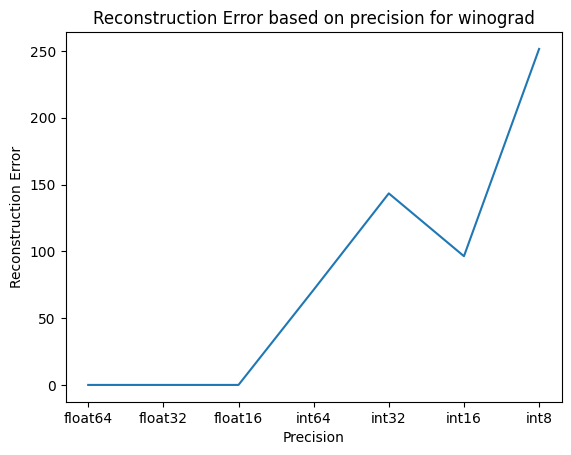

[0.0, 3.352752754245958e-12, 0.0, 71.23668670654297, 143.36094665527344, 96.34911346435547, 251.49111938476562]


In [15]:
from src.conv2d import winograd
error_list = calculate_reconstruction_errors("winograd", precisions)
print(error_list)

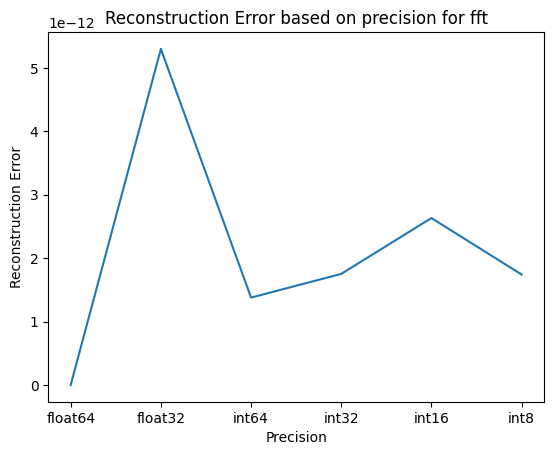

[0.0, 5.300901211036102e-12, 1.3776961342581995e-12, 1.751824163162552e-12, 2.63262393655761e-12, 1.7422171561323752e-12]


In [23]:
from src.conv2d import fft
error_list = calculate_reconstruction_errors("fft", precisions)
print(error_list)

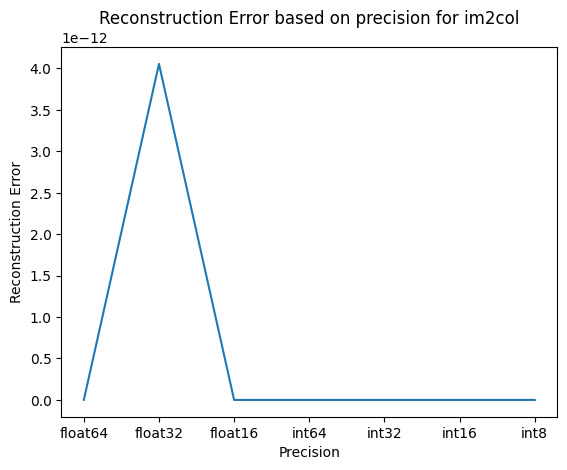

[0.0, 4.052363913181756e-12, 0.0, 0.0, 0.0, 0.0, 0.0]


In [17]:
from src.conv2d import im2col
error_list = calculate_reconstruction_errors("im2col", precisions)
print(error_list)

# 3. Matrix-matrix Multiply

In the following cell(s), please plot the reconstruction error (in the y-axis)
with the different numerical precisions (in the x-axis) for `log` (i.e.
logorithmic matrix-matrix multiplication).

Precision: float64, Error: 0.0
Precision: float32, Error: 4.132588856009534e-06
Precision: int64, Error: 8.477105097881577e-07
Precision: int32, Error: 1.589457156114804e-06
Precision: int16, Error: 4.238552548940788e-07
Precision: int8, Error: 1.589457156114804e-06
[0.0, 4.132588856009534e-06, 8.477105097881577e-07, 1.589457156114804e-06, 4.238552548940788e-07, 1.589457156114804e-06]


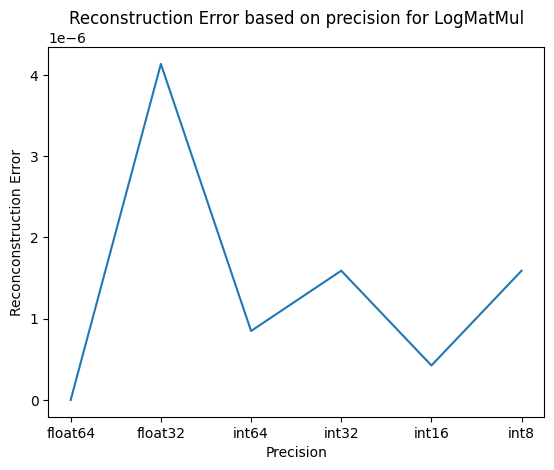

In [18]:
import sys
sys.path.insert(0, PROJECT_ROOT)

from src.matmul import logmatmul


precisions = [torch.float64, torch.float32, torch.int64, torch.int32, torch.int16, torch.int8]
strings = ['float64', 'float32', 'int64', 'int32', 'int16', 'int8']

def get_matmul_error(M, N, K, precision, int_type, method='log'):
    if int_type:
        A = torch.randint(-5, 5, size=(M, N), dtype=precision)
        B = torch.randint(-5, 5, size=(N, K), dtype=precision)
    else:
        A = torch.randn(M, N, dtype=precision) * 5
        B = torch.randn(N, K, dtype=precision) * 5

    if method == 'log':
        out = logmatmul(A, B)
    elif method == 'torch':
        out = torch.matmul(A, B)
    else:
        raise ValueError("Invalid method specified.")

    ans = torch.matmul(A, B)
    return F.l1_loss(ans.float(), out.float()).item()


errors = []
for i, p in enumerate(precisions):
    torch_error = get_matmul_error(3, 10, 3, p, i > 1, method='torch')
    log_error = get_matmul_error(3, 10, 3, p, i > 1, method='log')
    error = abs(torch_error - log_error)
    errors.append(error)
    print(f"Precision: {strings[i]}, Error: {error}")

print(errors)
plt.plot(strings, errors)
plt.title("Reconstruction Error based on precision for LogMatMul")
plt.xlabel("Precision")
plt.ylabel("Reconconstruction Error")
plt.show()

# Testing and Git

In [ ]:
%cd {PROJECT_ROOT}
!python -m pytest tests/test_conv2d.py

/content/gdrive/MyDrive/ece5545/a4-eminmdzd
============================= test session starts ==============================
platform linux -- Python 3.11.12, pytest-8.3.5, pluggy-1.5.0
rootdir: /content/gdrive/MyDrive/ece5545/a4-eminmdzd
plugins: typeguard-4.4.2, anyio-4.9.0, langsmith-0.3.31
collected 84 items                                                             

tests/test_conv2d.py ................................................... [ 60%]
.................................                                        [100%]

======================== 84 passed in 102.13s (0:01:42) ========================


In [ ]:
!python -m pytest tests/test_matmul.py

============================= test session starts ==============================
platform linux -- Python 3.11.12, pytest-8.3.5, pluggy-1.5.0
rootdir: /content/gdrive/MyDrive/ece5545/a4-eminmdzd
plugins: typeguard-4.4.2, anyio-4.9.0, langsmith-0.3.31
collected 84 items                                                             

tests/test_matmul.py ................................................... [ 60%]
.................................                                        [100%]

============================= 84 passed in 24.74s ==============================


In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	src/__pycache__/
	tests/__pycache__/

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
!git config --global user.email "em876@cornell.edu"
!git config --global user.name "Emin M"
!git add src/conv2d.py src/matmul.py
!git commit -m "Updated conv2d and matmul"

[main be7a390] Updated conv2d and matmul
 2 files changed, 178 insertions(+), 108 deletions(-)
 rewrite src/conv2d.py (70%)
 rewrite src/matmul.py (60%)


In [ ]:
!git push

Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 2.21 KiB | 84.00 KiB/s, done.
Total 5 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/ML-HW-SYS/a4-eminmdzd.git
   2c0f2c9..be7a390  main -> main
